# Sensitivity Analysis: RfR
### The goal is to intervene in the system, starting from the parameters to which the model is most sensitive.
Global sensitivity analysis: uncertain inputs are sampled at the same time (e.g. with Monte Carlo/Latin Hypercube), instead of checking each input separately, next we try to understand how uncertainty in model output is a function of uncertainty in model input.
#### The following sensitivity analysis aims to:
- Find which uncertain inputs are more influential on outputs;
- How much of the uncertainty is epistemic; how much is irreducible;
- Which uncertain inputs should be a priority for research;
- Which inputs be left out/aggregated to simplify the model.

#### Methods:
- Sobol sampling

## Import packages

In [120]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (Model, 
                           ScalarOutcome,
                           TimeSeriesOutcome,
                           IntegerParameter,
                           CategoricalParameter,
                           RealParameter, 
                           perform_experiments, 
                           ema_logging,
                           Policy, 
                           MultiprocessingEvaluator, 
                           save_results, 
                           load_results, 
                           Scenario)

from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

from dike_model_function import DikeNetwork  # @UnresolvedImport
from dike_model_function_time_series import DikeNetworkTS  # @UnresolvedImport
from problem_formulation_V2_5 import get_model_for_actor_problem_formulation

ema_workbench.__version__

'2.0.3'

## Importing the model
Importing the RfR model using a custom function for convenience.

In [34]:
# Problem formulations:
#    get_model_for_actor_problem_formulation(problem_formulation_id, outcome_type='time_series')
#    problem_formulation_id options
#        1 - RWS (GOOD)
#        2 - Environmental interest group
#        3 - Transport company 
#        4 - Delta commission
#        5 - Gelderland (GOOD)
#        6 - Overijssel (GOOD)s
#        7 - Dike rings 1 and 2
#        8 - Dike ring 3
#        9 - Dike ring 4
#        10 - Dike ring 5
#
#    outcome_type options
#        'time_series' (default)
#        'scalar'

model, planning_steps = get_model_for_actor_problem_formulation(1, outcome_type='scalar')

# Sobol global sensitivity analysis over Uncertainties and Levers

In [65]:
# Define uncertainties and convert them to SALib desired format
uncertainties = []
for unc in model.uncertainties:
    uncertainties.append(unc)

problem = get_SALib_problem(uncertainties)

In [36]:
# # Define the 'non-policy', setting all policy levers to zero
levers = []
for lev in model.levers:
    levers.append(lev)
    
# non_policy = Policy("No action", **{l.name:0 for l in levers})

In [39]:
# Perform experiments using Sobol sampling over uncertainties, evaluating over non_policy

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenario = 1000

with MultiprocessingEvaluator(model) as evaluator:
    experiments_sobol, outcomes_sobol = evaluator.perform_experiments(scenarios=n_scenario,
                                                                      uncertainty_sampling=SOBOL)
    
results_uncertainty = experiments_sobol, outcomes_sobol

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 102000 scenarios * 1 policies * 1 model(s) = 102000 experiments
[MainProcess/INFO] 10200 cases completed
[MainProcess/INFO] 20400 cases completed
[MainProcess/INFO] 30600 cases completed
[MainProcess/INFO] 40800 cases completed
[MainProcess/INFO] 51000 cases completed
[MainProcess/INFO] 61200 cases completed
[MainProcess/INFO] 71400 cases completed
[MainProcess/INFO] 81600 cases completed
[MainProcess/INFO] 91800 cases completed
[MainProcess/INFO] 102000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [40]:
save_results(results_uncertainty,'Outputs/experiments_sobol_102000_cases.tar.gz' )

[MainProcess/INFO] results saved successfully to /Users/philipseijger/Dropbox (Personal)/EPA/EPA1361-ModelBasedDecisionMaking/mbdm_1_RfR/SensitivityAnalysisSobol/Outputs/experiments_sobol_102000_cases.tar.gz


In [41]:
# Expected Annual Damage Sobol outcomes
EAD_final_sobol = outcomes_sobol['Expected Annual Damage']
EAD_score = sobol.analyze(problem, EAD_final_sobol, calc_second_order=True, print_to_console=False)

# Total Investment Costs Sobol outcomes - USING non-policy THIS REMAINS ZERO
TIC_final_sobol = outcomes_sobol['Total Investment Costs']
TIC_score = sobol.analyze(problem, TIC_final_sobol, calc_second_order=True, print_to_console=False)

# Expected Number of Deaths Sobol outcomes
END_final_sobol = outcomes_sobol['Expected Number of Deaths']
END_score = sobol.analyze(problem, END_final_sobol, calc_second_order=True, print_to_console=False)

In [227]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def plot_sobol_interaction(sobol_score):
    Si_filter = {k:sobol_score[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(16,12)
    fig.subplots_adjust(bottom=0.3)
    plt.title('Sobol ' + get_df_name(sobol_score))
    ax.set(xlabel='Uncertainty', ylabel='Fraction of total variance')
    plt.show()
    
# We can also study the convergence of the Sobol indices as a function of the number of samples,
# by computing the indices over a partial sample:

def plot_sobol_convergence(final_sobol):

    s_data = pd.DataFrame(index=problem['names'],
                          columns=np.arange(1,n_scenario,60)*(2*problem['num_vars']+2))
    for j in s_data.columns:
        scores = sobol.analyze(problem, final_sobol[0:j], calc_second_order=True, print_to_console=False)
        s_data.loc[:,j] = scores['ST']
        
    fig, ax = plt.subplots(1)
    fig.set_size_inches(16,10)

    s_data.T.plot(ax=ax)
    ax.set_xlabel('Samples')
    ax.set_xlim(left=0, right=102000)
    ax.set_ylabel('Total index (ST)')
    plt.title('Sobol Convergence ' + get_df_name(final_sobol))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

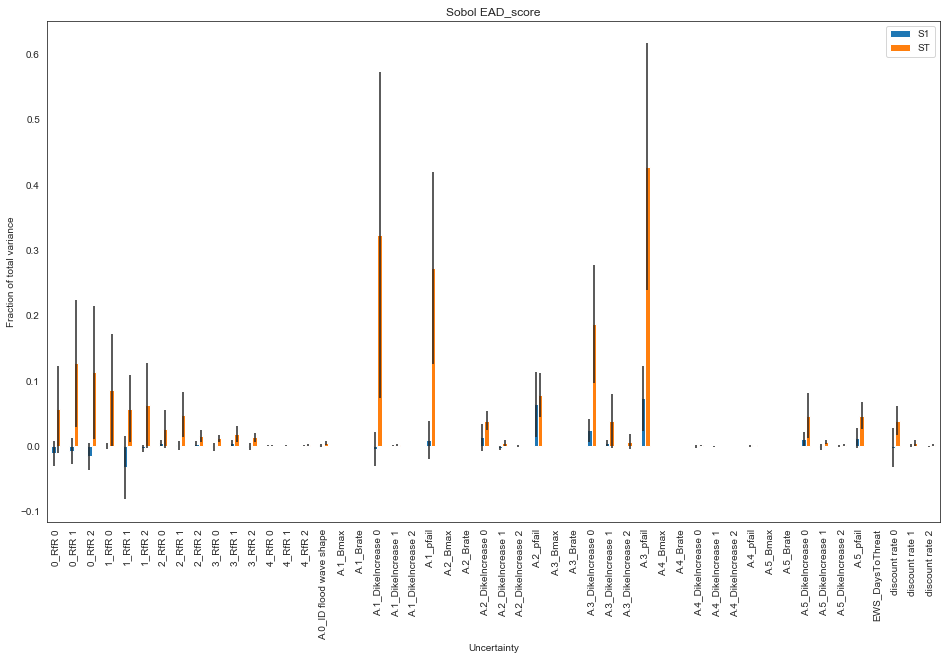

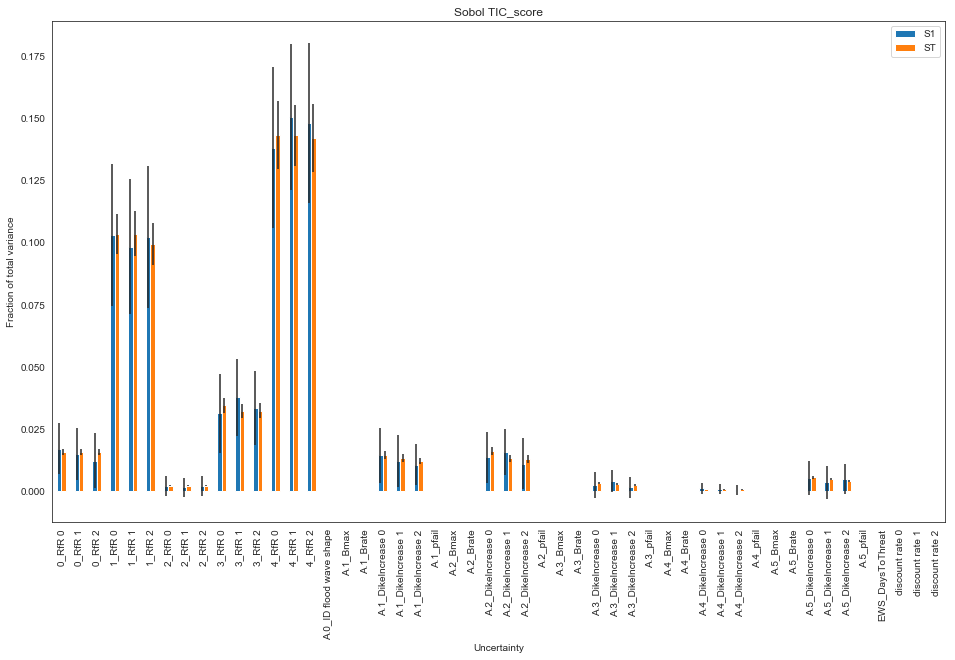

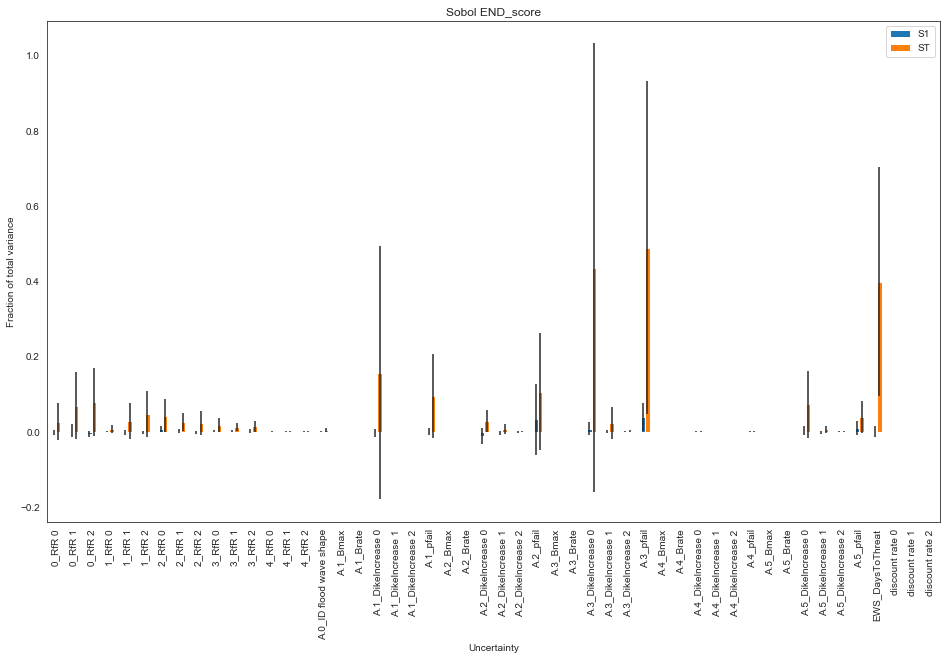

In [56]:
plot_sobol_interaction(EAD_score)
plot_sobol_interaction(TIC_score)
plot_sobol_interaction(END_score)

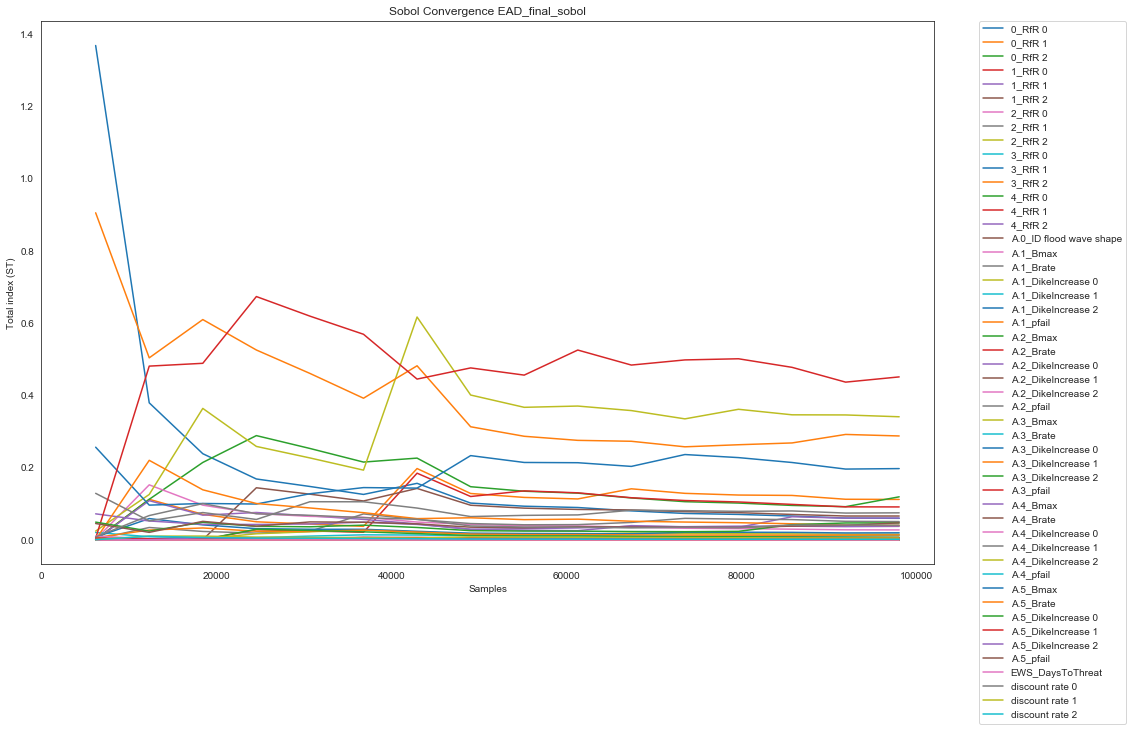

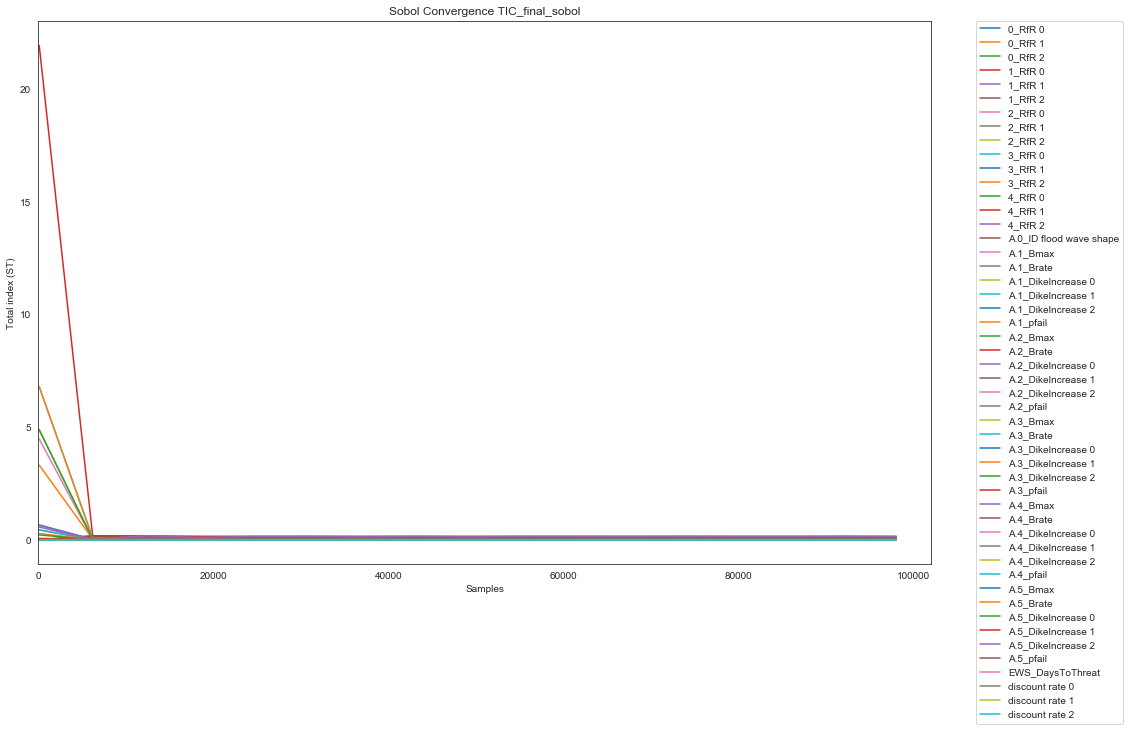

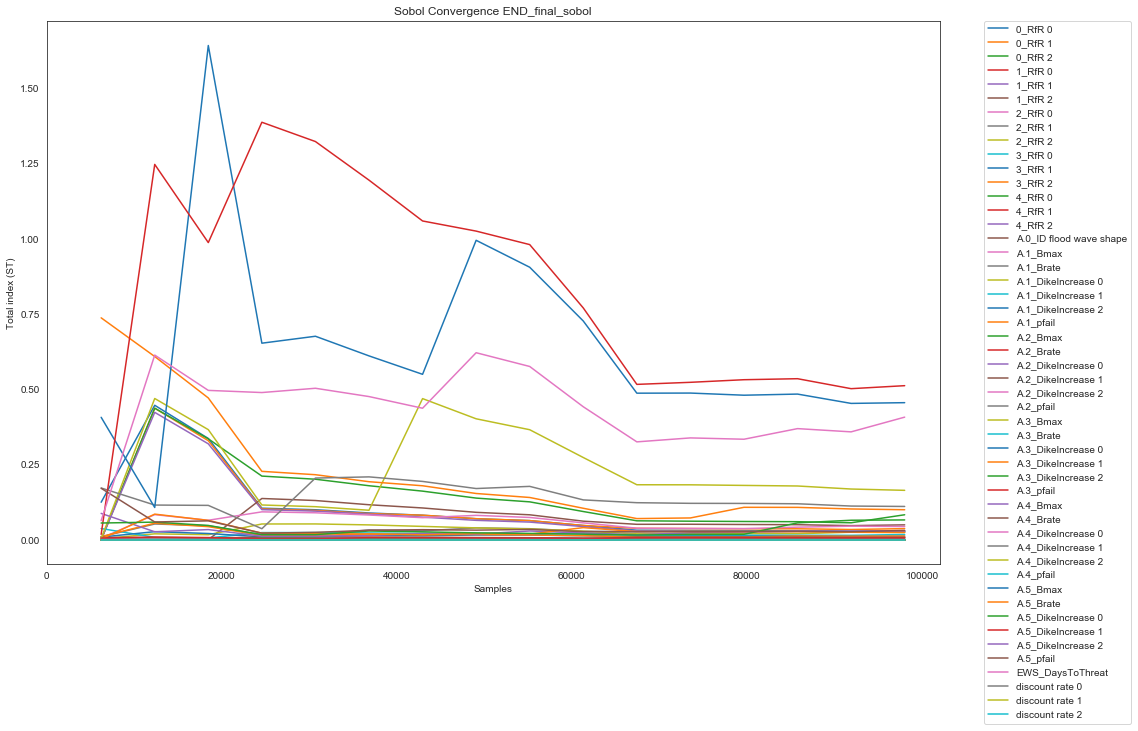

In [228]:
plot_sobol_convergence(EAD_final_sobol)
plot_sobol_convergence(TIC_final_sobol)
plot_sobol_convergence(END_final_sobol)

In [229]:
x={key:EAD_score[key] for key in ['ST', 'ST_conf', 'S1', 'S1_conf']}
x= pd.DataFrame(x, index=problem['names'])
x=x.drop(['S1', 'S1_conf', 'ST_conf'], axis=1)
x.columns = x.columns + '_' + 'EAD'

In [230]:
y={key:TIC_score[key] for key in ['ST', 'ST_conf', 'S1', 'S1_conf']}
y= pd.DataFrame(y, index=problem['names'])
y=y.drop(['S1', 'S1_conf', 'ST_conf'], axis=1)
y.columns = y.columns + '_' + 'TIC'

In [231]:
z={key:END_score[key] for key in ['ST', 'ST_conf', 'S1', 'S1_conf']}
z= pd.DataFrame(z, index=problem['names'])
z=z.drop(['S1', 'S1_conf', 'ST_conf'], axis=1)
z.columns = z.columns + '_' + 'END'

In [207]:
sensitivity_results = pd.concat([x, y, z], axis=1, sort=False)
sensitivity_results.head()

,ST_EAD,ST_TIC,ST_END
0_RfR 0,0.056033,0.015607,0.026167
0_RfR 1,0.126126,0.015607,0.068890
0_RfR 2,0.112336,0.015607,0.079167
1_RfR 0,0.085848,0.103445,0.007206
1_RfR 1,0.056767,0.103445,0.028499


In [232]:
q = .2
to_ignore = sensitivity_results[(sensitivity_results['ST_EAD'] < sensitivity_results['ST_EAD'].quantile(q)) 
                  & (sensitivity_results['ST_TIC'] < sensitivity_results['ST_TIC'].quantile(q)) 
                  & (sensitivity_results['ST_END'] < sensitivity_results['ST_END'].quantile(q))].index

to_ignore

Index(['A.1_Brate', 'A.2_Brate', 'A.3_Brate', 'A.4_Brate', 'A.5_Bmax',
       'A.5_Brate'],
      dtype='object')